In [1]:
import numpy as np
import random
import math
import os
import matplotlib.pyplot as plt
import pandas as pd
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
# import torchvision
# %matplotlib inline

from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')


In [3]:
# def drop_outlier(array,count,bins):
#     index = []
#     range_ = np.arange(1,count,bins)
#     for i in range_[:-1]:
#         array_lim = array[i:i+bins]
#         sigma = np.std(array_lim)
#         mean = np.mean(array_lim)
#         th_max,th_min = mean + sigma*2, mean - sigma*2
#         idx = np.where((array_lim < th_max) & (array_lim > th_min))
#         idx = idx[0] + i
#         index.extend(list(idx))
#     return np.array(index)

In [4]:
import pandas as pd
import os
from glob import glob

# Path to CS2_35 folder
folder_path = "CS2_35"
file_pattern = os.path.join(folder_path, "CS2_35_*.xlsx")
all_files = sorted(glob(file_pattern))

# Split files into train, validation, and test sets
train_files = all_files[:3]  # First 3 files for training
val_files = all_files[4:5]  # Next 2 files for validation
test_files = all_files[5:6]  # Next 2 files for testing

# Load and count rows for a given set of files
def load_and_count_rows(files):
    df_list = []
    total_rows = 0
    for file in files:
        try:
            df = pd.read_excel(file, sheet_name='Channel_1-008')  # Explicit sheet name
            rows = len(df)
            total_rows += rows
            df_list.append(df)  # Store the dataframe for further use
            print(f"Loaded {file} with {rows} rows")
        except Exception as e:
            print(f"Failed to load {file}: {e}")
    return df_list, total_rows

# Load data for training (first 3 files)
print("\nLoading Training Data (First 3 files):")
train_dfs, train_row_count = load_and_count_rows(train_files)
print(f"\nTotal rows for training: {train_row_count}")

# Load data for validation (next 2 files)
print("\nLoading Validation Data (Next 2 files):")
val_dfs, val_row_count = load_and_count_rows(val_files)
print(f"\nTotal rows for validation: {val_row_count}")

# Load data for testing (next 2 files)
print("\nLoading Testing Data (Next 2 files):")
test_dfs, test_row_count = load_and_count_rows(test_files)
print(f"\nTotal rows for testing: {test_row_count}")

# Combine all data into DataFrames for easier use in model training
train_data = pd.concat(train_dfs, ignore_index=True)
val_data = pd.concat(val_dfs, ignore_index=True)
test_data = pd.concat(test_dfs, ignore_index=True)

# Final Output (Summary)
print(f"\nTotal number of rows used for training: {train_row_count}")
print(f"Total number of rows used for validation: {val_row_count}")
print(f"Total number of rows used for testing: {test_row_count}")

# Now, you have:
# 1. train_data (training set)
# 2. val_data (validation set)
# 3. test_data (test set)



Loading Training Data (First 3 files):
Channel_1-008
Info
Loaded CS2_35\CS2_35_10_15_10.xlsx with 17139 rows
Channel_1-008
Info
Loaded CS2_35\CS2_35_10_22_10.xlsx with 16629 rows
Channel_1-008
Info
Statistics_1-008
Loaded CS2_35\CS2_35_10_29_10.xlsx with 16334 rows

Total rows for training: 50102

Loading Validation Data (Next 2 files):
Channel_1-008
Info
Statistics_1-008
Loaded CS2_35\CS2_35_11_08_10.xlsx with 16506 rows

Total rows for validation: 16506

Loading Testing Data (Next 2 files):
Channel_1-008
Info
Statistics_1-008
Loaded CS2_35\CS2_35_11_23_10.xlsx with 16433 rows

Total rows for testing: 16433

Total number of rows used for training: 50102
Total number of rows used for validation: 16506
Total number of rows used for testing: 16433


In [5]:
# Inspect combined training data
print("\n--- Combined Training Data ---")
display(train_data.head())  # First 5 rows
print(f"Shape: {train_data.shape}")
print("=" * 50)

# Inspect combined validation data
print("\n--- Combined Validation Data ---")
display(val_data.head())  # First 5 rows
print(f"Shape: {val_data.shape}")
print("=" * 50)

# Inspect combined testing data
print("\n--- Combined Testing Data ---")
display(test_data.head())  # First 5 rows
print(f"Shape: {test_data.shape}")
print("=" * 50)



--- Combined Training Data ---


,Data_Point,Test_Time(s),Date_Time,Step_Time(s),Step_Index,Cycle_Index,Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),dV/dt(V/s),Internal_Resistance(Ohm),Is_FC_Data,AC_Impedance(Ohm),ACI_Phase_Angle(Deg)
0,1,30.000525,2010-10-08 14:29:45,30.000525,1,1,0.000000,3.424221,0.000000,0.0,0.000000,0.0,0.000032,0.0,0,0,0
1,2,60.015702,2010-10-08 14:30:15,60.015703,1,1,0.000000,3.424382,0.000000,0.0,0.000000,0.0,0.000032,0.0,0,0,0
2,3,90.030813,2010-10-08 14:30:45,90.030813,1,1,0.000000,3.424382,0.000000,0.0,0.000000,0.0,0.000032,0.0,0,0,0
3,4,120.014345,2010-10-08 14:31:15,120.014346,1,1,0.000000,3.424382,0.000000,0.0,0.000000,0.0,0.000000,0.0,0,0,0
4,5,150.030510,2010-10-08 14:31:46,30.015733,2,1,0.550117,3.567489,0.004587,0.0,0.016232,0.0,0.001392,0.0,0,0,0


Shape: (50102, 17)

--- Combined Validation Data ---


,Data_Point,Test_Time(s),Date_Time,Step_Time(s),Step_Index,Cycle_Index,Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),dV/dt(V/s),Internal_Resistance(Ohm),Is_FC_Data,AC_Impedance(Ohm),ACI_Phase_Angle(Deg)
0,1,30.000460,2010-11-01 14:23:58,30.000461,1,1,0.000000,3.702016,0.000000,0.0,0.000000,0.0,0.000000,0.0,0,0,0
1,2,60.015773,2010-11-01 14:24:28,60.015774,1,1,0.000000,3.702016,0.000000,0.0,0.000000,0.0,-0.000032,0.0,0,0,0
2,3,90.030864,2010-11-01 14:24:58,90.030864,1,1,0.000000,3.702016,0.000000,0.0,0.000000,0.0,0.000000,0.0,0,0,0
3,4,120.014324,2010-11-01 14:25:28,120.014325,1,1,0.000000,3.702016,0.000000,0.0,0.000000,0.0,0.000032,0.0,0,0,0
4,5,150.015114,2010-11-01 14:25:58,30.000352,2,1,0.550297,3.792511,0.004585,0.0,0.017353,0.0,0.000324,0.0,0,0,0


Shape: (16506, 17)

--- Combined Testing Data ---


,Data_Point,Test_Time(s),Date_Time,Step_Time(s),Step_Index,Cycle_Index,Current(A),Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),Charge_Energy(Wh),Discharge_Energy(Wh),dV/dt(V/s),Internal_Resistance(Ohm),Is_FC_Data,AC_Impedance(Ohm),ACI_Phase_Angle(Deg)
0,1,30.000987,2010-11-16 11:45:27,30.000988,1,1,0.000000,3.695217,0.000000,0.0,0.000000,0.0,0.000000,0.0,0,0,0
1,2,60.016142,2010-11-16 11:45:57,60.016143,1,1,0.000000,3.695217,0.000000,0.0,0.000000,0.0,0.000000,0.0,0,0,0
2,3,90.031419,2010-11-16 11:46:27,90.031420,1,1,0.000000,3.695217,0.000000,0.0,0.000000,0.0,-0.000032,0.0,0,0,0
3,4,120.015334,2010-11-16 11:46:57,120.015335,1,1,0.000000,3.695217,0.000000,0.0,0.000000,0.0,0.000032,0.0,0,0,0
4,5,150.031300,2010-11-16 11:47:27,30.015546,2,1,0.550117,3.785064,0.004587,0.0,0.017327,0.0,0.000291,0.0,0,0,0


Shape: (16433, 17)


In [6]:
features = [ 'Cycle_Index',
            'Voltage(V)',
            'Charge_Capacity(Ah)',
            'Discharge_Capacity(Ah)', 
            'Internal_Resistance(Ohm)']

In [7]:


# Filter necessary columns for each combined dataset
train_data = train_data[features]
val_data = val_data[features]
test_data = test_data[features]

# Optionally display the filtered data
print("\n--- Filtered Training Data ---")
display(train_data.head())
print("=" * 50)

print("\n--- Filtered Validation Data ---")
display(val_data.head())
print("=" * 50)

print("\n--- Filtered Testing Data ---")
display(test_data.head())
print("=" * 50)



--- Filtered Training Data ---


,Cycle_Index,Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),Internal_Resistance(Ohm)
0,1,3.424221,0.000000,0.0,0.0
1,1,3.424382,0.000000,0.0,0.0
2,1,3.424382,0.000000,0.0,0.0
3,1,3.424382,0.000000,0.0,0.0
4,1,3.567489,0.004587,0.0,0.0



--- Filtered Validation Data ---


,Cycle_Index,Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),Internal_Resistance(Ohm)
0,1,3.702016,0.000000,0.0,0.0
1,1,3.702016,0.000000,0.0,0.0
2,1,3.702016,0.000000,0.0,0.0
3,1,3.702016,0.000000,0.0,0.0
4,1,3.792511,0.004585,0.0,0.0



--- Filtered Testing Data ---


,Cycle_Index,Voltage(V),Charge_Capacity(Ah),Discharge_Capacity(Ah),Internal_Resistance(Ohm)
0,1,3.695217,0.000000,0.0,0.0
1,1,3.695217,0.000000,0.0,0.0
2,1,3.695217,0.000000,0.0,0.0
3,1,3.695217,0.000000,0.0,0.0
4,1,3.785064,0.004587,0.0,0.0


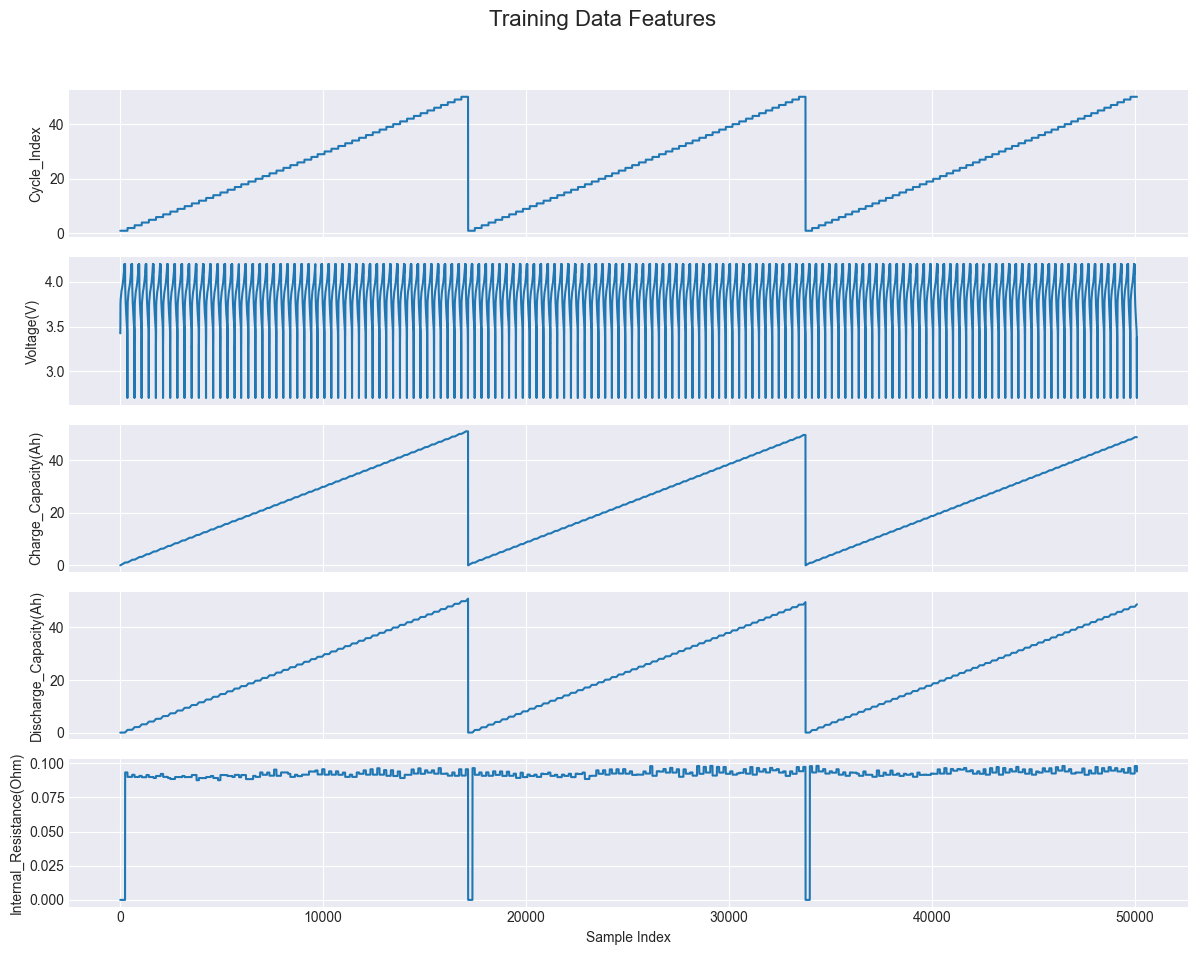

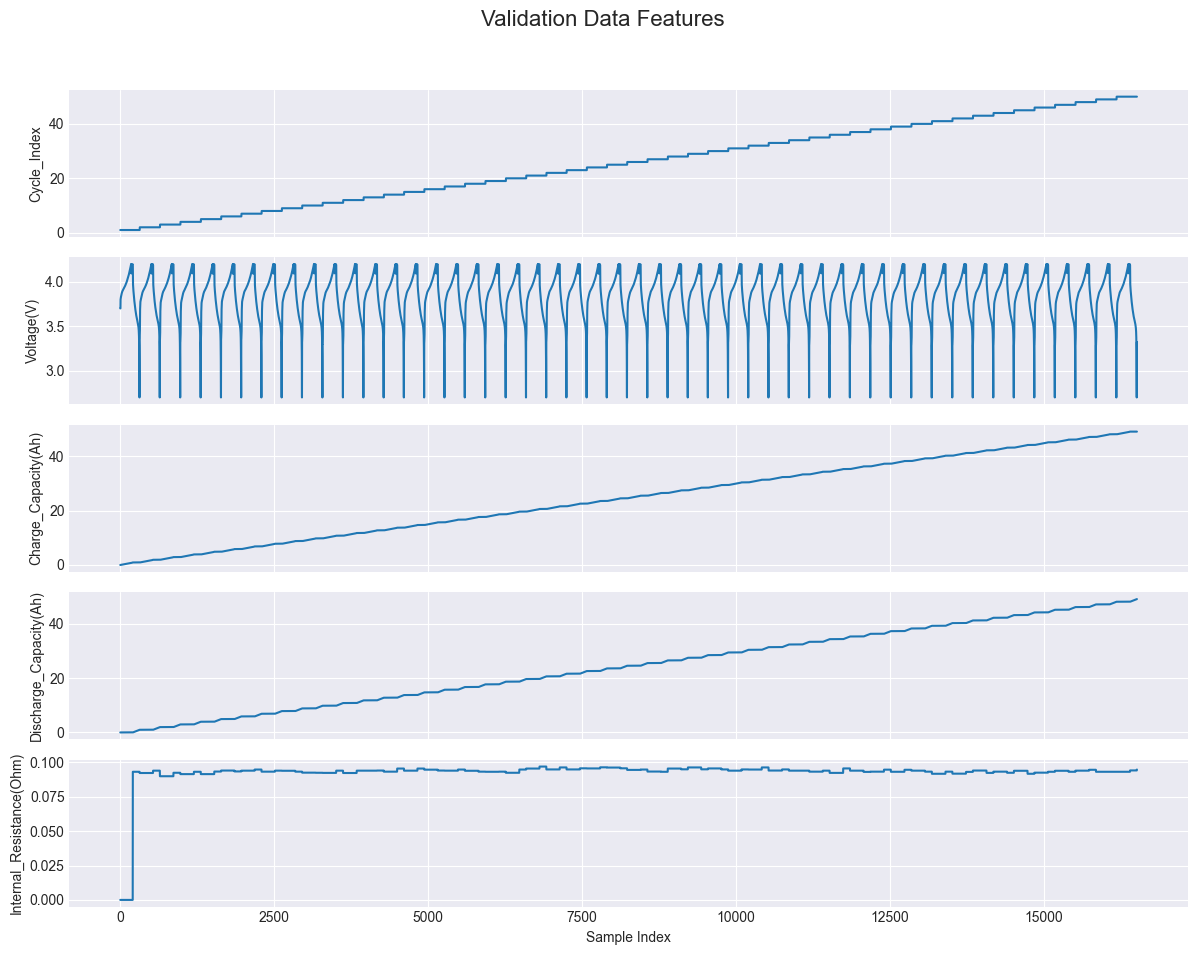

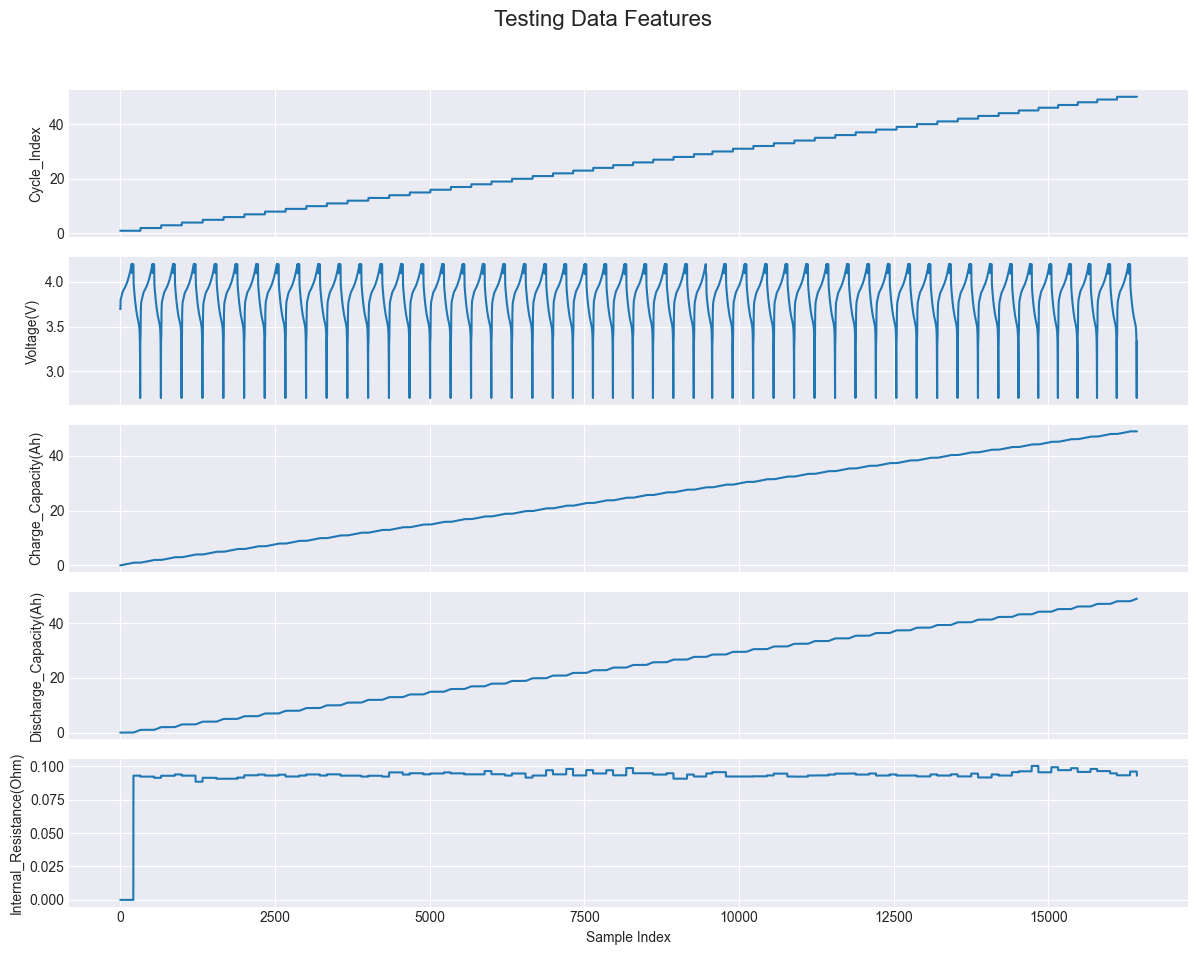

In [8]:
import matplotlib.pyplot as plt

# Set the plotting style
plt.style.use('seaborn-v0_8-darkgrid')

# Define a function to plot features
def plot_features(df, title):
    fig, axs = plt.subplots(len(df.columns), 1, figsize=(12, 10), sharex=True)
    fig.suptitle(title, fontsize=16)
    
    for i, column in enumerate(df.columns):
        axs[i].plot(df[column].values)
        axs[i].set_ylabel(column)
    
    axs[-1].set_xlabel('Sample Index')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Plot each dataset
plot_features(train_data, "Training Data Features")
plot_features(val_data, "Validation Data Features")
plot_features(test_data, "Testing Data Features")


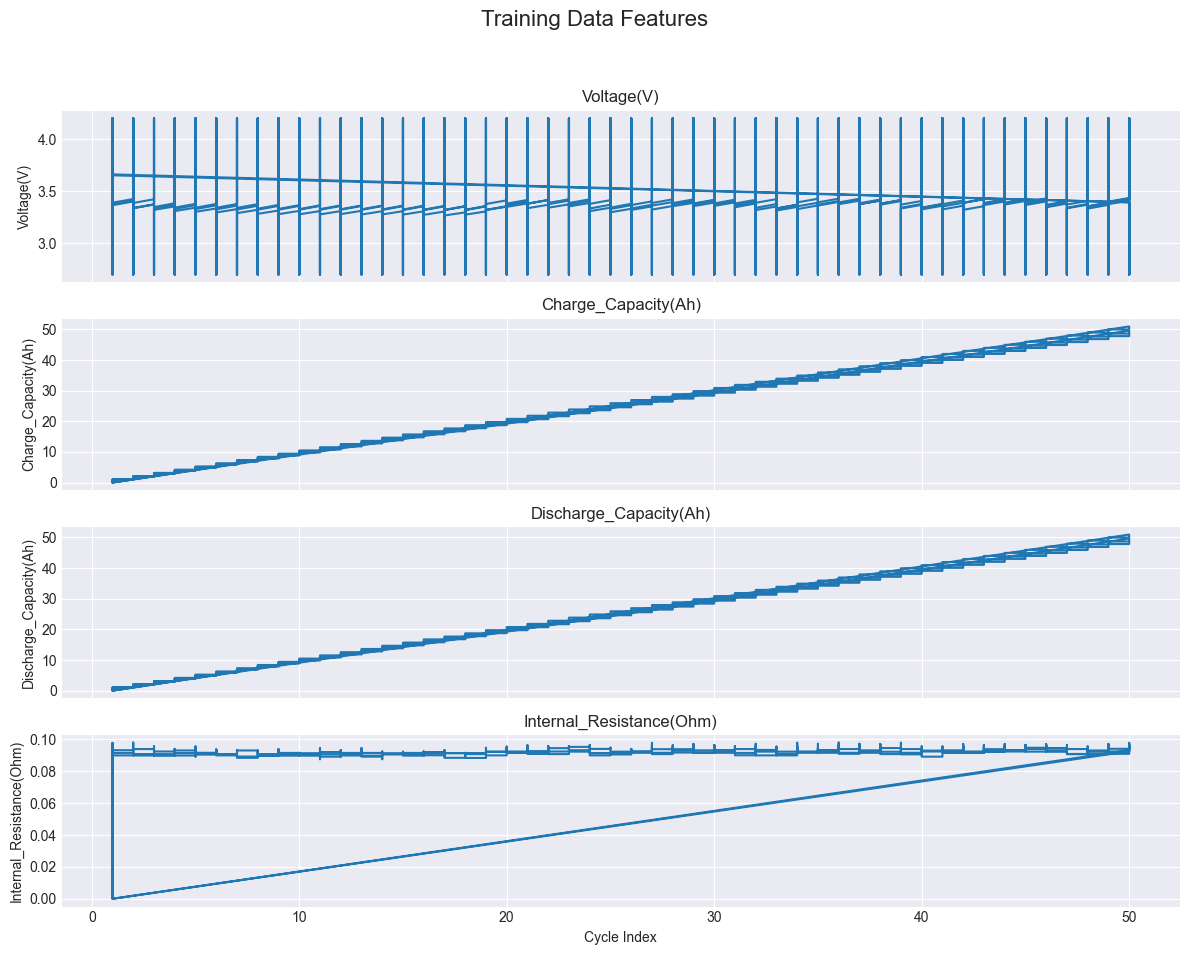

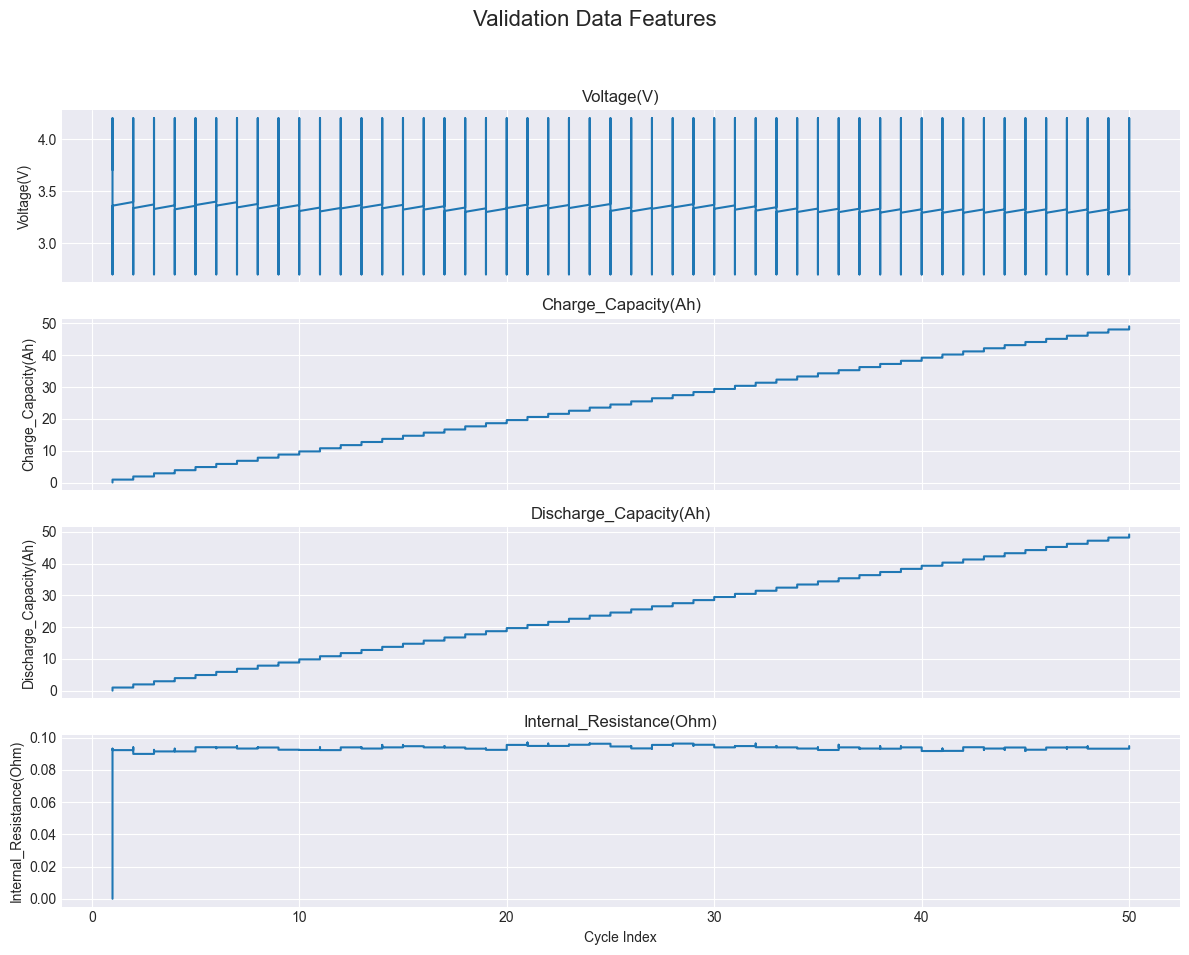

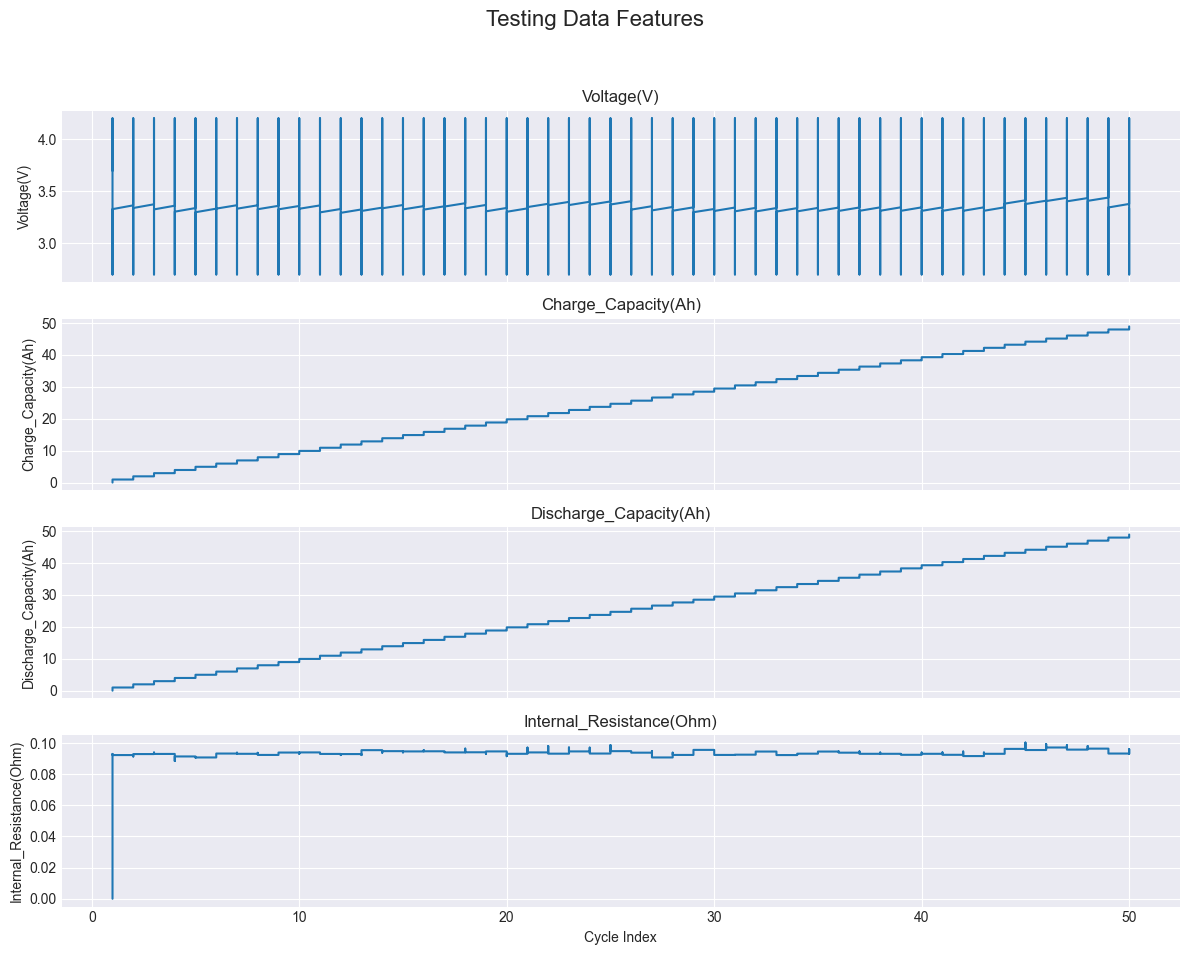

In [9]:
import matplotlib.pyplot as plt

# List available styles (for reference)


# Set the plotting style
plt.style.use('seaborn-v0_8-darkgrid')

# Define a function to plot selected features
def plot_features(df, title):
    # Automatically select columns if they exist

    available_columns = [col for col in features if col in df.columns]
    
    # Extract 'Cycle_Index' if available
    cycle_available = 'Cycle_Index' in available_columns
    features_to_plot = [col for col in available_columns if col != 'Cycle_Index']

    # Use 'Cycle_Index' for x-axis or index if not available
    x = df['Cycle_Index'] if cycle_available else df.index

    # Plot the features
    fig, axs = plt.subplots(len(features_to_plot), 1, figsize=(12, 10), sharex=True)
    fig.suptitle(title, fontsize=16)

    for i, column in enumerate(features_to_plot):
        axs[i].plot(x, df[column])
        axs[i].set_ylabel(column)
        axs[i].set_title(column)

    axs[-1].set_xlabel('Cycle Index' if cycle_available else 'Sample Index')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

# Plot the datasets
plot_features(train_data, "Training Data Features")
plot_features(val_data, "Validation Data Features")
plot_features(test_data, "Testing Data Features")


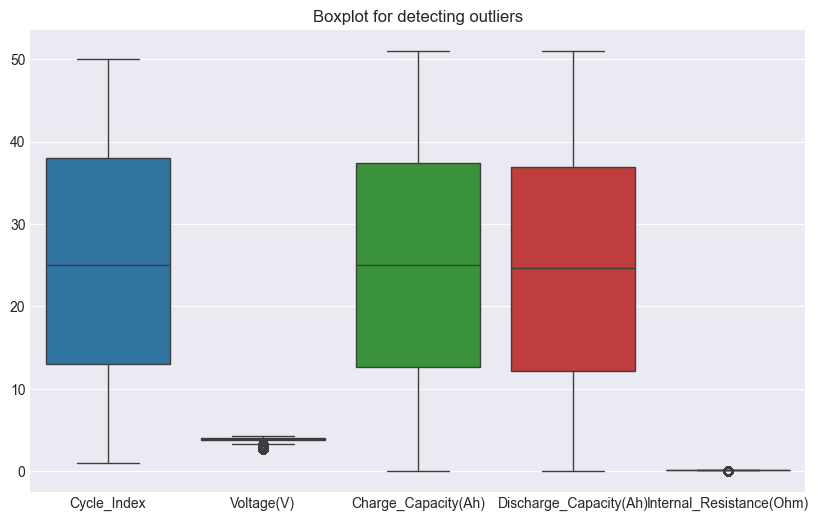

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Boxplot for detecting outliers
plt.figure(figsize=(10, 6))
sns.boxplot(data=train_data)
plt.title("Boxplot for detecting outliers")
plt.show()

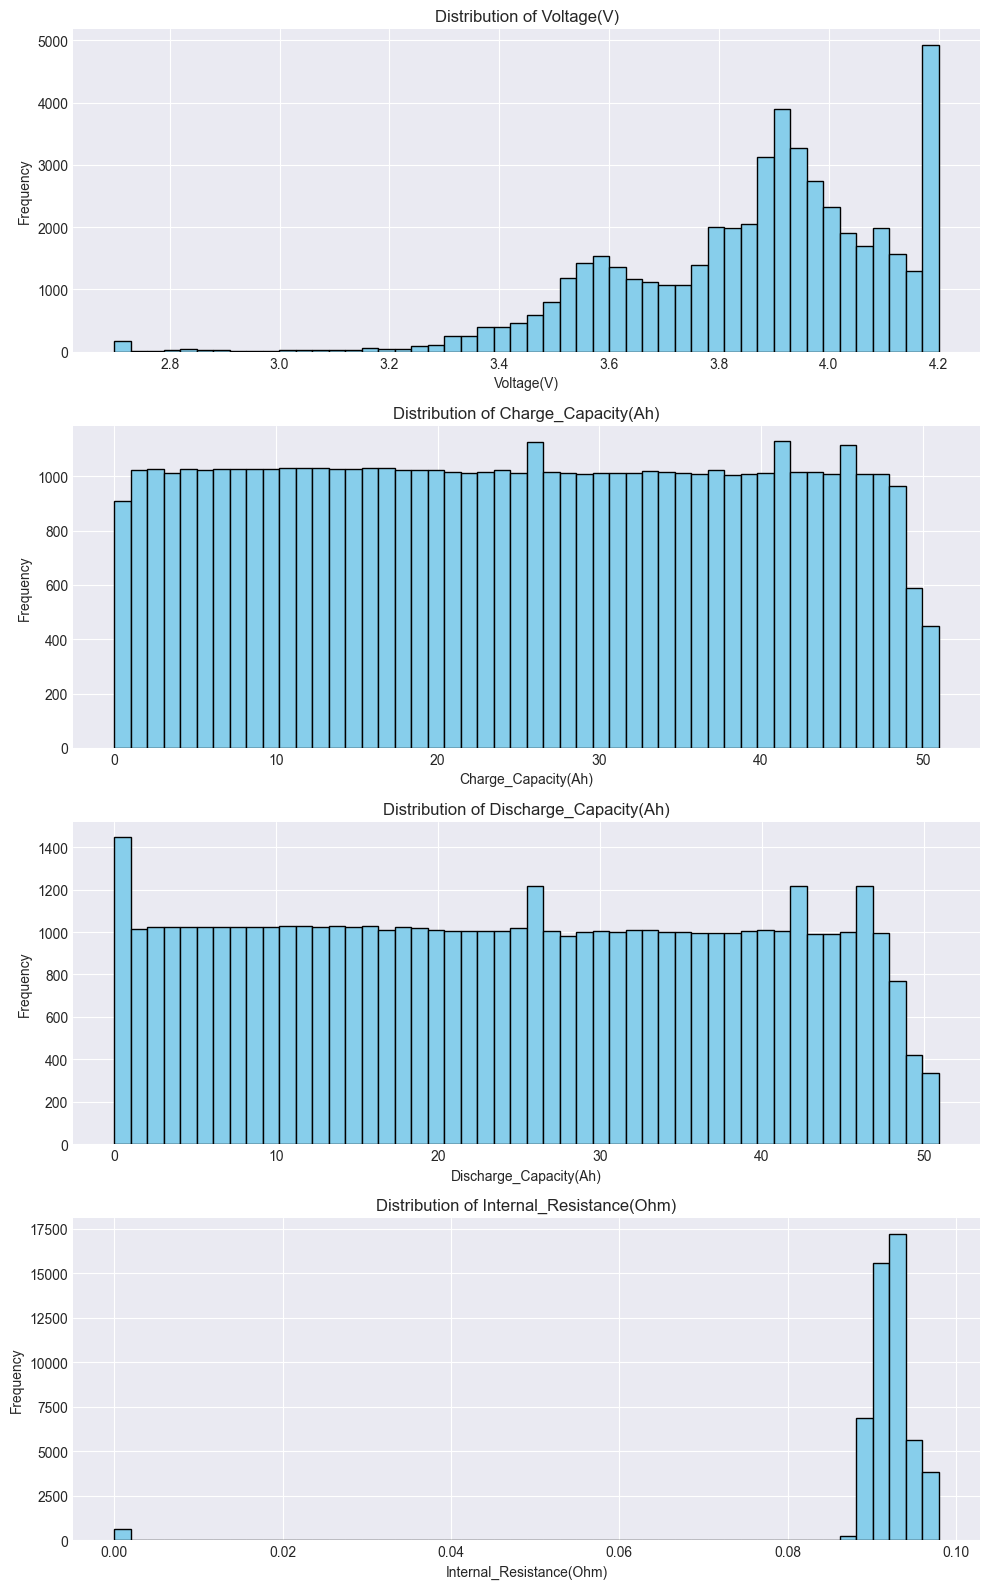

In [11]:
import matplotlib.pyplot as plt

# List of features to plot (excluding 'Cycle_Index')
selected_features = [f for f in features if f != 'Cycle_Index']

# Adjust figure size depending on number of features
plt.figure(figsize=(10, 4 * len(selected_features)))  # Dynamic height

for i, feature in enumerate(selected_features, 1):
    plt.subplot(len(selected_features), 1, i)
    plt.hist(train_data[feature], bins=50, color='skyblue', edgecolor='black')
    plt.title(f"Distribution of {feature}")
    plt.xlabel(feature)
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()


In [12]:
from sklearn.preprocessing import MinMaxScaler
import pandas as pd

# Exclude 'Cycle_Index' from features
selected_features = [f for f in features if f != 'Cycle_Index']

# Filter datasets to include only the selected features
train_data = train_data[selected_features]
val_data = val_data[selected_features]
test_data = test_data[selected_features]

# Initialize MinMaxScaler
scaler = MinMaxScaler()

# Scale the training, validation, and testing data
train_data_scaled = scaler.fit_transform(train_data)
val_data_scaled = scaler.transform(val_data)
test_data_scaled = scaler.transform(test_data)

# Convert to DataFrame for inspection
# train_scaled_df = pd.DataFrame(train_data_scaled, columns=selected_features)
# display(train_scaled_df.head())


In [62]:
import numpy as np

sequence_length = 67

# Function to create sequences with the shape (samples, 4, 67)
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        # The new sequence should have 4 features and 67 timesteps
        X.append(data[i:i + sequence_length].T)  # Transpose the sequence: (4, 67)
        y.append(data[i + sequence_length, 0])  # You can select the first feature or any other feature for the target
    return np.array(X), np.array(y)

# Assuming train_data_scaled, val_data_scaled, and test_data_scaled have shape (samples, 4)
X_train, y_train = create_sequences(train_data_scaled, sequence_length)
X_val, y_val = create_sequences(val_data_scaled, sequence_length)
X_test, y_test = create_sequences(test_data_scaled, sequence_length)

# Check the shapes
print("X_train shape:", X_train.shape)  # Should print (50035, 4, 67)
print("y_train shape:", y_train.shape)  # Should print (50035, )
print("X_val shape:", X_val.shape)      # Should print (3181, 4, 67)
print("y_val shape:", y_val.shape)      # Should print (3181, )
print("X_test shape:", X_test.shape)    # Should print (16439, 4, 67)
print("y_test shape:", y_test.shape)    # Should print (16439, )


X_train shape: (50035, 4, 67)
y_train shape: (50035,)
X_val shape: (16439, 4, 67)
y_val shape: (16439,)
X_test shape: (16366, 4, 67)
y_test shape: (16366,)


In [63]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [72]:
from torch.utils.data import DataLoader, TensorDataset
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoader for batching
batch_size = 512 # You can change the batch size as needed
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check the shapes of the first batch
for batch_x, batch_y in train_loader:
    print(f"Batch x shape: {batch_x.shape}")  # Should be [batch_size, 67, 1]
    print(f"Batch y shape: {batch_y.shape}")  # Should be [batch_size, 1]
    break  # Only print the first batch for inspection

Batch x shape: torch.Size([512, 4, 67])
Batch y shape: torch.Size([512])


### GRU MODEL

In [33]:

PATH = 'GRU_model.pth'  # Path to the saved weights
GRU_model = torch.load(PATH, map_location=torch.device('cpu'),weights_only=False)

GRU_model =GRU_model.backbone
GRU_model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
GRU_model.to(device)  # Move the model to the device

SOHMode(
  (pre_net): Linear(in_features=67, out_features=512, bias=True)
  (backbone): GRU(
    (net): GRU(4, 128, num_layers=2, batch_first=True)
    (predictor): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (mse): MSELoss()
)

In [143]:
def calculate_metrics_sklearn(y_true, y_pred):
    """Calculate R², MAE, MSE, and MAPE using sklearn metrics."""
    # R²
    r2 = r2_score(y_true, y_pred)

    # MAE (Mean Absolute Error)
    mae = mean_absolute_error(y_true, y_pred)

    # MSE (Mean Squared Error)
    mse = mean_squared_error(y_true, y_pred)

    # MAPE (Mean Absolute Percentage Error)
    # mape = mean_absolute_percentage_error(y_true, y_pred) * 100  # Multiply by 100 to get percentage

    return r2, mae, mse

def Train(model, train_loader, valid_loader, test_loader, args, save_folder=None):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)  # Ensure the model is on the correct device

    # Initialize optimizer and scheduler
    optimizer = torch.optim.Adam(model.parameters(), lr=args.lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=args.step_size, gamma=args.gamma)

    # Define loss function
    mse_loss = torch.nn.MSELoss()

    min_loss = 10
    stop = 0
    train_losses = []
    valid_losses = []
    best_state = None

    # Store metrics for train, validation, and test
    train_r2_values = []
    valid_r2_values = []

    for e in range(1, args.n_epoch + 1):
        # --------- Train one epoch manually ---------
        model.train()
        train_loss = 0
        all_train_preds = []
        all_train_labels = []
        for data, label in train_loader:
            data, label = data.to(device), label.to(device)
            label = label.unsqueeze(1)
            # print("Data batch shape:", data.shape)  # Should be [512, ...]
            # print("Label batch shape:", label.shape)
            pred = model(data)
            # print("Predicted shape:", pred.shape)
            # print("Target shape:", label.shape)
            loss = mse_loss(pred, label)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            all_train_preds.append(pred.cpu().detach().numpy())
            all_train_labels.append(label.cpu().detach().numpy())

        train_loss /= len(train_loader)
        train_losses.append(train_loss)

        # Calculate metrics for training
        all_train_preds = np.concatenate(all_train_preds, axis=0)
        all_train_labels = np.concatenate(all_train_labels, axis=0)
        train_r2, train_mae,train_mse = calculate_metrics_sklearn(all_train_labels, all_train_preds)
        train_r2_values.append(train_r2)

        scheduler.step()

        # --------- Validation manually ---------
        model.eval()
        valid_loss = 0
        all_valid_preds = []
        all_valid_labels = []
        with torch.no_grad():
            for data, label in valid_loader:
                data, label = data.to(device), label.to(device)
                label = label.unsqueeze(1)
                pred = model(data)
                loss = mse_loss(pred, label)
                valid_loss += loss.item()

                all_valid_preds.append(pred.cpu().detach().numpy())
                all_valid_labels.append(label.cpu().detach().numpy())

        valid_loss /= len(valid_loader)
        valid_losses.append(valid_loss)

        # Calculate metrics for validation
        all_valid_preds = np.concatenate(all_valid_preds, axis=0)
        all_valid_labels = np.concatenate(all_valid_labels, axis=0)
        valid_r2, valid_mae, valid_mse = calculate_metrics_sklearn(all_valid_labels, all_valid_preds)
        valid_r2_values.append(valid_r2)

        lr = optimizer.state_dict()['param_groups'][0]['lr']
        
        # Print each epoch's training and validation results
        print(f"Epoch [{e}/{args.n_epoch}] - Train Loss: {train_loss:.5f} | Train R²: {train_r2:.5f} | Train MAE: {train_mae:.5f} | Train MSE: {train_mse:.5f}")
        print(f"             - Valid Loss: {valid_loss:.5f} | Valid R²: {valid_r2:.5f} | Valid MAE: {valid_mae:.5f} | Valid MSE: {valid_mse:.5f}")
    
        
        if e % 10 == 0:
            print()  # Newline every 10 epochs for clarity
        delta = 1e-3 
        # --------- Save best model ---------
        if valid_loss < min_loss - delta:
            best_state = model.state_dict()
            min_loss = valid_loss
            stop = 0
        else: stop += 1
        # --------- Early stopping ---------
        if stop >= args.early_stop:
            print("\nEarly stopping triggered.")
            break

    # --------- After all epochs, evaluate on test set ---------
    test_loss = 0
    all_test_preds = []
    all_test_labels = []
    with torch.no_grad():
        for data, label in test_loader:
            data, label = data.to(device), label.to(device)
            label = label.unsqueeze(1)
            pred = model(data)
            loss = mse_loss(pred, label)
            test_loss += loss.item()

            all_test_preds.append(pred.cpu().detach().numpy())
            all_test_labels.append(label.cpu().detach().numpy())

    test_loss /= len(test_loader)

    # Flatten the predictions and labels for metric calculations
    all_test_preds = np.concatenate(all_test_preds, axis=0)
    all_test_labels = np.concatenate(all_test_labels, axis=0)
    
    # Calculate metrics for test set
    test_r2, test_mae, test_mse = calculate_metrics_sklearn(all_test_labels, all_test_preds)

    # Print test results at the end of training
    print(f"Final Test Loss: {test_loss:.5f}, Test R²: {test_r2:.5f}, Test MAE: {test_mae:.5f}, Test MSE: {test_mse:.5f}")

    # --------- Save model ---------
    # if save_folder is not None and best_state is not None:
    #     torch.save(best_state, save_folder + '/best_model.pth')

    return train_losses, valid_losses, train_r2_values, valid_r2_values, test_loss, test_r2,all_test_labels, all_test_preds


In [37]:
class Args:
    n_epoch = 100
    lr = 0.0001
    step_size = 30
    gamma = 0.5
    early_stop = 10

args = Args()
train_losses, valid_losses, train_r2_values, valid_r2_values, test_loss, test_r2 ,all_test_labels, all_test_preds = Train(GRU_model, train_loader, val_loader, test_loader, args, save_folder="my_models")

Epoch [1/100] - Train Loss: 0.02700 | Train R²: -0.01501 | Train MAE: 0.12818 | Train MSE: 0.02698
             - Valid Loss: 0.02672 | Valid R²: 0.07342 | Valid MAE: 0.12384 | Valid MSE: 0.02519
Epoch [2/100] - Train Loss: 0.02411 | Train R²: 0.09372 | Train MAE: 0.12064 | Train MSE: 0.02409
             - Valid Loss: 0.02509 | Valid R²: 0.13176 | Valid MAE: 0.11842 | Valid MSE: 0.02360
Epoch [3/100] - Train Loss: 0.02101 | Train R²: 0.20987 | Train MAE: 0.11162 | Train MSE: 0.02100
             - Valid Loss: 0.01945 | Valid R²: 0.32622 | Valid MAE: 0.10021 | Valid MSE: 0.01832
Epoch [4/100] - Train Loss: 0.01389 | Train R²: 0.47703 | Train MAE: 0.08939 | Train MSE: 0.01390
             - Valid Loss: 0.01163 | Valid R²: 0.58599 | Valid MAE: 0.07614 | Valid MSE: 0.01125
Epoch [5/100] - Train Loss: 0.00806 | Train R²: 0.69649 | Train MAE: 0.06594 | Train MSE: 0.00807
             - Valid Loss: 0.00765 | Valid R²: 0.72923 | Valid MAE: 0.05949 | Valid MSE: 0.00736
Epoch [6/100] - Train Lo

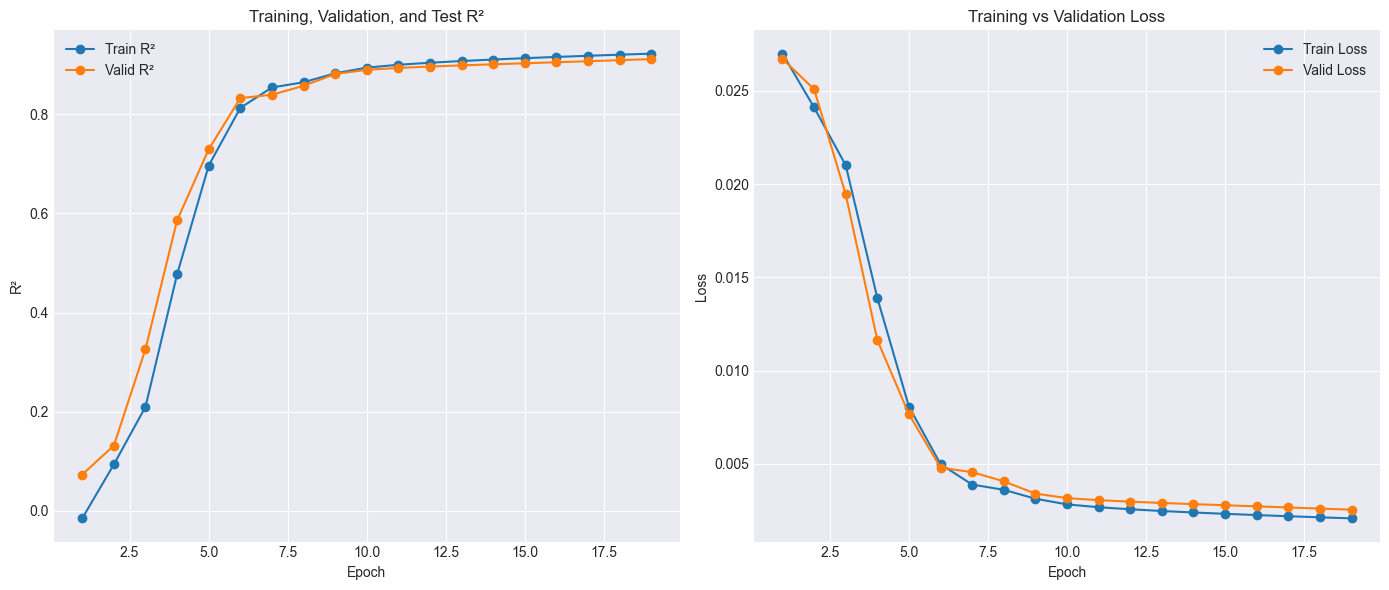

In [38]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))
# R² Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_r2_values, label='Train R²', marker='o')
plt.plot(epochs, valid_r2_values, label='Valid R²', marker='o')

plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Training, Validation, and Test R²')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, valid_losses, label='Valid Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [42]:

PATH = 'GRU_model.pth'  # Path to the saved weights
GRU_model = torch.load(PATH, map_location=torch.device('cpu'),weights_only=False)

GRU_model =GRU_model.backbone
GRU_model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
GRU_model.to(device)  # Move the model to the device

GRU(
  (net): GRU(4, 128, num_layers=2, batch_first=True)
  (predictor): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [43]:
for name, param in GRU_model.named_parameters():
    if 'predictor' not in name:  # This checks if the parameter is not in the 'predictor' layer
        param.requires_grad = False
    else:
        param.requires_grad = True  # Allow the last layer to be trainable

In [44]:
class Args:
    n_epoch = 100
    lr = 0.0001
    step_size = 30
    gamma = 0.5
    early_stop = 10

args = Args()
train_losses, valid_losses, train_r2_values, valid_r2_values, test_loss, test_r2 ,all_test_labels, all_test_preds= Train(GRU_model, train_loader, val_loader, test_loader, args)

Epoch [1/100] - Train Loss: 0.03312 | Train R²: -0.24562 | Train MAE: 0.13777 | Train MSE: 0.03311
             - Valid Loss: 0.02707 | Valid R²: 0.06320 | Valid MAE: 0.12406 | Valid MSE: 0.02546
Epoch [2/100] - Train Loss: 0.02503 | Train R²: 0.05950 | Train MAE: 0.12323 | Train MSE: 0.02500
             - Valid Loss: 0.02708 | Valid R²: 0.06325 | Valid MAE: 0.12392 | Valid MSE: 0.02546
Epoch [3/100] - Train Loss: 0.02503 | Train R²: 0.05954 | Train MAE: 0.12317 | Train MSE: 0.02500
             - Valid Loss: 0.02708 | Valid R²: 0.06328 | Valid MAE: 0.12397 | Valid MSE: 0.02546
Epoch [4/100] - Train Loss: 0.02503 | Train R²: 0.05953 | Train MAE: 0.12317 | Train MSE: 0.02500
             - Valid Loss: 0.02707 | Valid R²: 0.06331 | Valid MAE: 0.12401 | Valid MSE: 0.02546
Epoch [5/100] - Train Loss: 0.02503 | Train R²: 0.05954 | Train MAE: 0.12317 | Train MSE: 0.02500
             - Valid Loss: 0.02707 | Valid R²: 0.06334 | Valid MAE: 0.12404 | Valid MSE: 0.02546
Epoch [6/100] - Train Lo

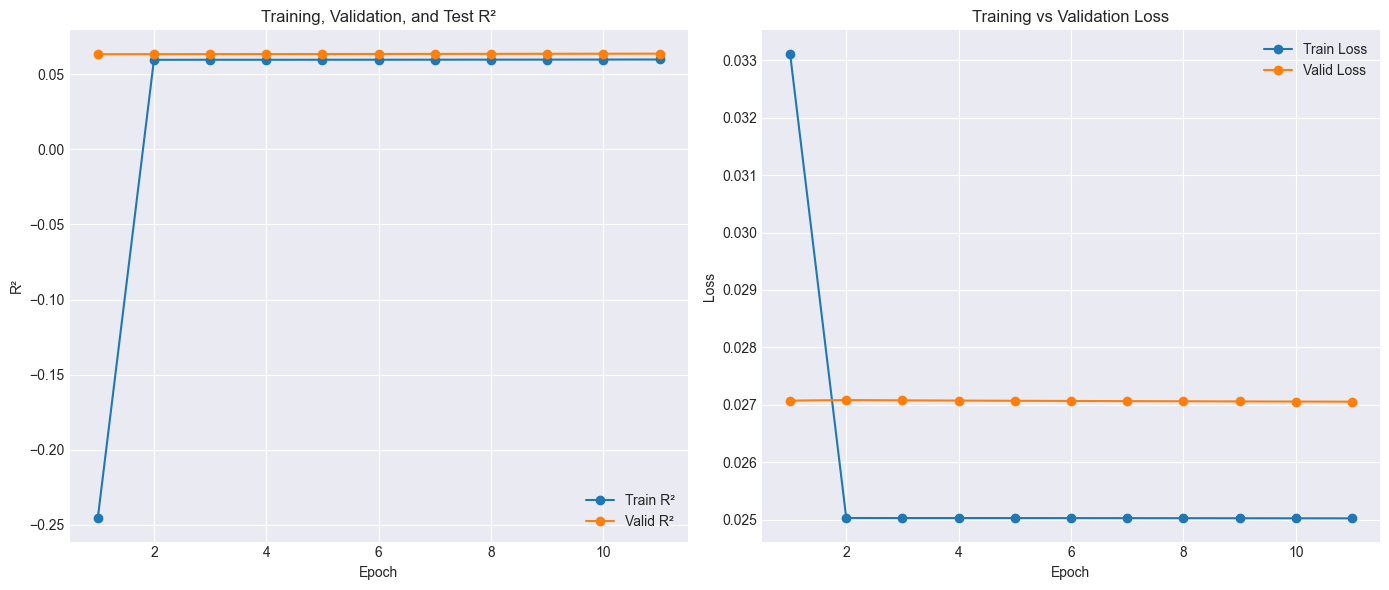

In [45]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))
# R² Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_r2_values, label='Train R²', marker='o')
plt.plot(epochs, valid_r2_values, label='Valid R²', marker='o')

plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Training, Validation, and Test R²')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, valid_losses, label='Valid Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### MLP MODEL

In [99]:
import torch
import numpy as np
from torch.utils.data import DataLoader, TensorDataset

sequence_length = 128

# Function to create sequences with the shape (samples, 4, 67)
def create_sequences(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        # The new sequence should have 4 features and 67 timesteps
        X.append(data[i:i + sequence_length].T)  # Transpose the sequence: (4, 67)
        y.append(data[i + sequence_length, 0])  # You can select the first feature or any other feature for the target
    return np.array(X), np.array(y)

# Assuming train_data_scaled, val_data_scaled, and test_data_scaled have shape (samples, 4)
X_train, y_train = create_sequences(train_data_scaled, sequence_length)
X_val, y_val = create_sequences(val_data_scaled, sequence_length)
X_test, y_test = create_sequences(test_data_scaled, sequence_length)

# Check the shapes
print("X_train shape:", X_train.shape)  # Should print (50035, 4, 67)
print("y_train shape:", y_train.shape)  # Should print (50035, )
print("X_val shape:", X_val.shape)      # Should print (3181, 4, 67)
print("y_val shape:", y_val.shape)      # Should print (3181, )
print("X_test shape:", X_test.shape)    # Should print (16439, 4, 67)
print("y_test shape:", y_test.shape)    # Should print (16439, )

# Convert to torch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

# Create TensorDataset and DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 512  # Change batch size as needed

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check the shapes of the first batch
for batch_x, batch_y in train_loader:
    print(f"Batch x shape: {batch_x.shape}")  # Should be [batch_size, 4, 67]
    print(f"Batch y shape: {batch_y.shape}")  # Should be [batch_size, 1]
    break  # Only print the first batch for inspection


X_train shape: (49974, 4, 128)
y_train shape: (49974,)
X_val shape: (16378, 4, 128)
y_val shape: (16378,)
X_test shape: (16305, 4, 128)
y_test shape: (16305,)
Batch x shape: torch.Size([512, 4, 128])
Batch y shape: torch.Size([512])


In [117]:

PATH = 'MLP_model.pth'  # Path to the saved weights
MLP_model = torch.load(PATH, map_location=torch.device('cpu'),weights_only=False)

MLP_model =MLP_model.backbone
MLP_model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MLP_model.to(device)  # Move the model to the device

SOHMode(
  (pre_net): Linear(in_features=67, out_features=512, bias=True)
  (backbone): MLP(
    (net): Sequential(
      (0): Linear(in_features=512, out_features=256, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.2, inplace=False)
      (3): Linear(in_features=256, out_features=128, bias=True)
      (4): ReLU()
    )
    (predictor): Sequential(
      (0): Linear(in_features=128, out_features=64, bias=True)
      (1): ReLU()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (mse): MSELoss()
)

In [120]:
class Args:
    n_epoch = 100
    lr = 0.0001
    step_size = 30
    gamma = 0.5
    early_stop = 10

args = Args()
train_losses, valid_losses, train_r2_values, valid_r2_values, test_loss, test_r2,all_test_labels, all_test_preds = Train(MLP_model, train_loader, val_loader, test_loader, args, save_folder="my_models")

Epoch [1/100] - Train Loss: 0.01617 | Train R²: 0.39113 | Train MAE: 0.09457 | Train MSE: 0.01620
             - Valid Loss: 0.01130 | Valid R²: 0.58555 | Valid MAE: 0.08401 | Valid MSE: 0.01130
Epoch [2/100] - Train Loss: 0.01020 | Train R²: 0.61656 | Train MAE: 0.07622 | Train MSE: 0.01020
             - Valid Loss: 0.01436 | Valid R²: 0.47310 | Valid MAE: 0.09544 | Valid MSE: 0.01436
Epoch [3/100] - Train Loss: 0.00871 | Train R²: 0.67223 | Train MAE: 0.07070 | Train MSE: 0.00872
             - Valid Loss: 0.00695 | Valid R²: 0.74496 | Valid MAE: 0.06193 | Valid MSE: 0.00695
Epoch [4/100] - Train Loss: 0.00718 | Train R²: 0.73025 | Train MAE: 0.06351 | Train MSE: 0.00718
             - Valid Loss: 0.00750 | Valid R²: 0.72485 | Valid MAE: 0.06905 | Valid MSE: 0.00750
Epoch [5/100] - Train Loss: 0.00646 | Train R²: 0.75712 | Train MAE: 0.05985 | Train MSE: 0.00646
             - Valid Loss: 0.00862 | Valid R²: 0.68382 | Valid MAE: 0.07345 | Valid MSE: 0.00862
Epoch [6/100] - Train Los

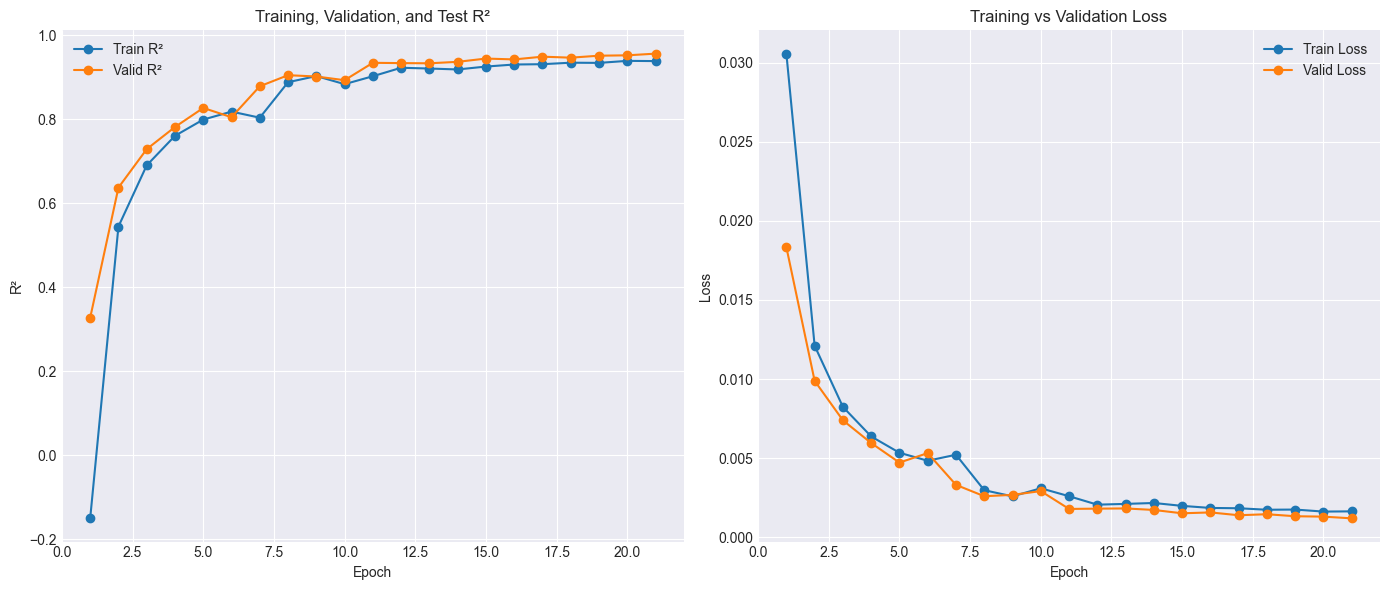

In [127]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))
# R² Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_r2_values, label='Train R²', marker='o')
plt.plot(epochs, valid_r2_values, label='Valid R²', marker='o')

plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Training, Validation, and Test R²')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, valid_losses, label='Valid Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### ATTENTİON MODEL

In [123]:

PATH = 'Attention_model.pth'  # Path to the saved weights
ATTENTİON_model = torch.load(PATH, map_location=torch.device('cpu'),weights_only=False)
ATTENTİON_model =ATTENTİON_model.backbone

# Set the model to evaluation mode
ATTENTİON_model.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
ATTENTİON_model.to(device)  # Move the model to the device

SOHMode(
  (pre_net): Linear(in_features=67, out_features=512, bias=True)
  (backbone): Attention(
    (encoder_layer): TransformerEncoderLayer(
      (self_attn): MultiheadAttention(
        (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
      )
      (linear1): Linear(in_features=128, out_features=128, bias=True)
      (dropout): Dropout(p=0.1, inplace=False)
      (linear2): Linear(in_features=128, out_features=128, bias=True)
      (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      (dropout1): Dropout(p=0.1, inplace=False)
      (dropout2): Dropout(p=0.1, inplace=False)
    )
    (transformer_encoder): TransformerEncoder(
      (layers): ModuleList(
        (0-1): 2 x TransformerEncoderLayer(
          (self_attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
          )
       

In [126]:
class Args:
    n_epoch = 100
    lr = 0.0001
    step_size = 30
    gamma = 0.5
    early_stop = 10

args = Args()
train_losses, valid_losses, train_r2_values, valid_r2_values, test_loss, test_r2,all_test_labels, all_test_preds = Train(ATTENTİON_model, train_loader, val_loader, test_loader, args, save_folder="my_models")

Epoch [1/100] - Train Loss: 0.03058 | Train R²: -0.15070 | Train MAE: 0.13522 | Train MSE: 0.03062
             - Valid Loss: 0.01834 | Valid R²: 0.32722 | Valid MAE: 0.09991 | Valid MSE: 0.01834
Epoch [2/100] - Train Loss: 0.01211 | Train R²: 0.54462 | Train MAE: 0.08417 | Train MSE: 0.01212
             - Valid Loss: 0.00988 | Valid R²: 0.63741 | Valid MAE: 0.08003 | Valid MSE: 0.00988
Epoch [3/100] - Train Loss: 0.00824 | Train R²: 0.69035 | Train MAE: 0.07181 | Train MSE: 0.00824
             - Valid Loss: 0.00739 | Valid R²: 0.72894 | Valid MAE: 0.06840 | Valid MSE: 0.00739
Epoch [4/100] - Train Loss: 0.00637 | Train R²: 0.76068 | Train MAE: 0.06099 | Train MSE: 0.00637
             - Valid Loss: 0.00595 | Valid R²: 0.78168 | Valid MAE: 0.05841 | Valid MSE: 0.00595
Epoch [5/100] - Train Loss: 0.00534 | Train R²: 0.79938 | Train MAE: 0.05250 | Train MSE: 0.00534
             - Valid Loss: 0.00471 | Valid R²: 0.82705 | Valid MAE: 0.04796 | Valid MSE: 0.00471
Epoch [6/100] - Train Lo

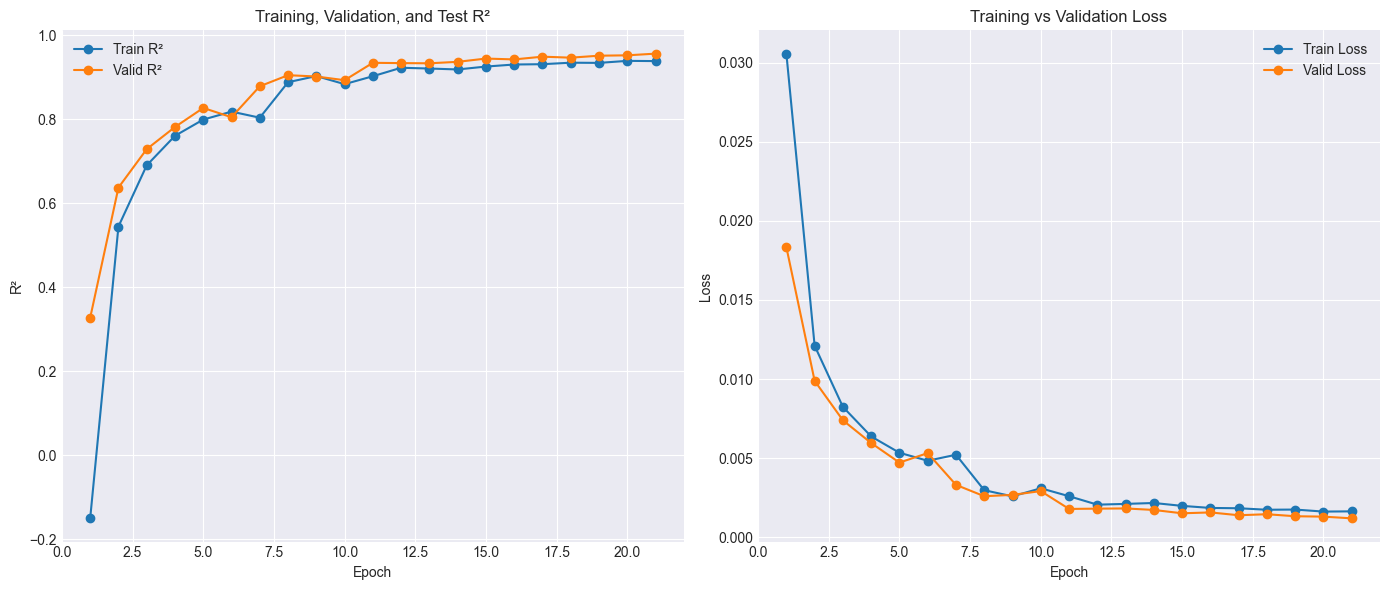

In [128]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))
# R² Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_r2_values, label='Train R²', marker='o')
plt.plot(epochs, valid_r2_values, label='Valid R²', marker='o')

plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Training, Validation, and Test R²')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, valid_losses, label='Valid Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### CNN MODEL

In [183]:

PATH = 'CNN_model.pth'  # Path to the saved weights
CNN_model = torch.load(PATH, map_location=torch.device('cpu'),weights_only=False)
CNN_model =CNN_model.backbone

# Set the model to evaluation mode
CNN_model.eval()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
CNN_model.to(device)  # Move the model to the device

CNN(
  (layer1): ResBlock(
    (conv): Sequential(
      (0): Conv1d(4, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv1d(16, 16, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (skip_connection): Sequential(
      (0): Conv1d(4, 16, kernel_size=(1,), stride=(1,))
      (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (relu): ReLU()
  )
  (layer2): ResBlock(
    (conv): Sequential(
      (0): Conv1d(16, 32, kernel_size=(3,), stride=(2,), padding=(1,))
      (1): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv1d(32, 32, kernel_size=(3,), stride=(1,), padding=(1,))
      (4): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
   

In [184]:
# for name, param in CNN_model.named_parameters():
#     if all(x not in name for x in ['predictor', 'layer4', 'layer5','layer3',]):
#         param.requires_grad = False  # Freeze everything else
#     else:
#         param.requires_grad = True   # Unfreeze predictor, layer4, layer5


In [189]:
# for name, param in CNN_model.named_parameters():
#     status = "Trainable" if param.requires_grad else "Frozen"
#     print(f"{name}: {status}")

In [186]:
class Args:
    n_epoch = 100
    lr = 0.0001
    step_size = 30
    gamma = 0.5
    early_stop = 10

args = Args()
train_losses, valid_losses, train_r2_values, valid_r2_values, test_loss, test_r2,all_test_labels, all_test_preds = Train(model, train_loader, val_loader, test_loader, args, save_folder="my_models")

Epoch [1/100] - Train Loss: 0.00128 | Train R²: 0.95199 | Train MAE: 0.02114 | Train MSE: 0.00128
             - Valid Loss: 0.00117 | Valid R²: 0.95721 | Valid MAE: 0.02065 | Valid MSE: 0.00117
Epoch [2/100] - Train Loss: 0.00174 | Train R²: 0.93457 | Train MAE: 0.02803 | Train MSE: 0.00174
             - Valid Loss: 0.00164 | Valid R²: 0.93966 | Valid MAE: 0.02854 | Valid MSE: 0.00164
Epoch [3/100] - Train Loss: 0.00132 | Train R²: 0.95018 | Train MAE: 0.02214 | Train MSE: 0.00133
             - Valid Loss: 0.00138 | Valid R²: 0.94947 | Valid MAE: 0.02458 | Valid MSE: 0.00138
Epoch [4/100] - Train Loss: 0.00121 | Train R²: 0.95455 | Train MAE: 0.02037 | Train MSE: 0.00121
             - Valid Loss: 0.00130 | Valid R²: 0.95234 | Valid MAE: 0.02349 | Valid MSE: 0.00130
Epoch [5/100] - Train Loss: 0.00120 | Train R²: 0.95488 | Train MAE: 0.02045 | Train MSE: 0.00120
             - Valid Loss: 0.00112 | Valid R²: 0.95895 | Valid MAE: 0.02013 | Valid MSE: 0.00112
Epoch [6/100] - Train Los

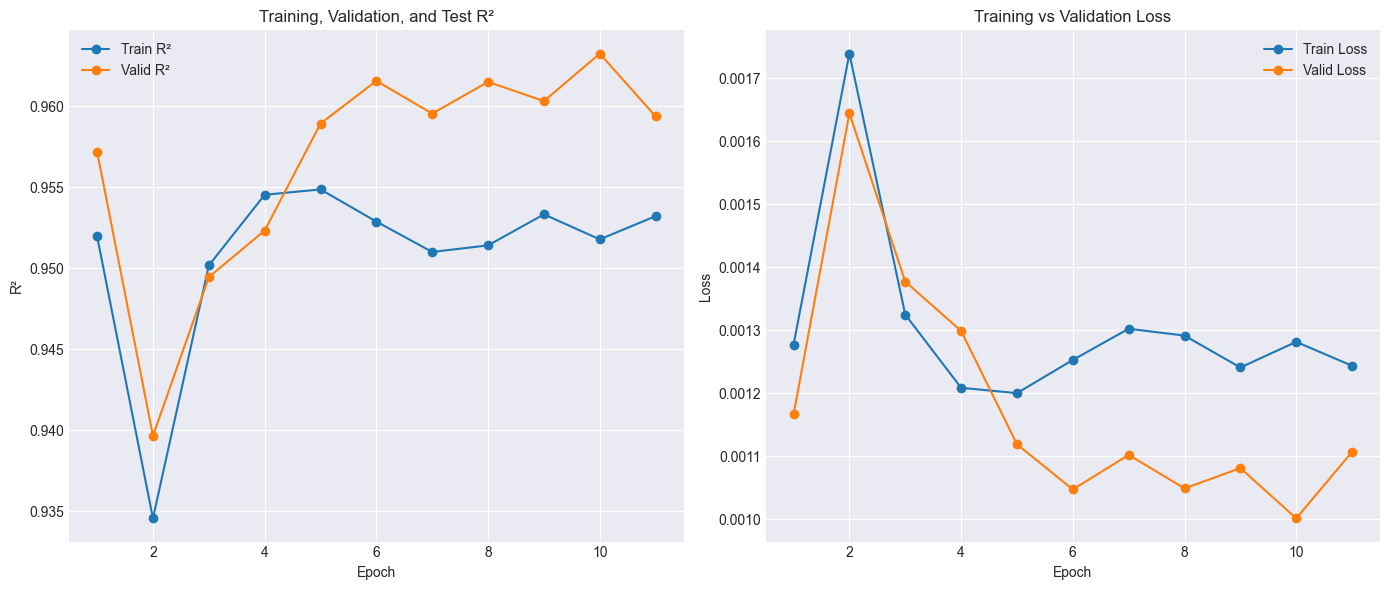

In [187]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))
# R² Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_r2_values, label='Train R²', marker='o')
plt.plot(epochs, valid_r2_values, label='Valid R²', marker='o')

plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Training, Validation, and Test R²')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, valid_losses, label='Valid Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


### LSTM MODEL

In [190]:
PATH = 'LSTM_model.pth'  # Path to the saved weights
LSTM_model = torch.load(PATH, map_location=torch.device('cpu'), weights_only=False)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LSTM_model.to(device)  # Move the model to the device

LSTM_model =LSTM_model.backbone

# Set the model to evaluation mode
LSTM_model.eval()


LSTM(
  (net): LSTM(4, 128, num_layers=2, batch_first=True)
  (predictor): Sequential(
    (0): Linear(in_features=128, out_features=64, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=64, out_features=1, bias=True)
  )
)

In [191]:
class Args:
    n_epoch = 100
    lr = 0.0001
    step_size = 30
    gamma = 0.5
    early_stop = 10

args = Args()
train_losses, valid_losses, train_r2_values, valid_r2_values, test_loss, test_r2,all_test_labels, all_test_preds = Train(LSTM_model, train_loader, val_loader, test_loader, args, save_folder="my_models")

Epoch [1/100] - Train Loss: 0.02362 | Train R²: 0.11218 | Train MAE: 0.11901 | Train MSE: 0.02363
             - Valid Loss: 0.02193 | Valid R²: 0.19553 | Valid MAE: 0.11153 | Valid MSE: 0.02193
Epoch [2/100] - Train Loss: 0.01828 | Train R²: 0.31242 | Train MAE: 0.10239 | Train MSE: 0.01830
             - Valid Loss: 0.01524 | Valid R²: 0.44074 | Valid MAE: 0.09096 | Valid MSE: 0.01524
Epoch [3/100] - Train Loss: 0.01270 | Train R²: 0.52213 | Train MAE: 0.08424 | Train MSE: 0.01272
             - Valid Loss: 0.01129 | Valid R²: 0.58569 | Valid MAE: 0.07166 | Valid MSE: 0.01129
Epoch [4/100] - Train Loss: 0.00987 | Train R²: 0.62869 | Train MAE: 0.07316 | Train MSE: 0.00988
             - Valid Loss: 0.00789 | Valid R²: 0.71054 | Valid MAE: 0.06212 | Valid MSE: 0.00789
Epoch [5/100] - Train Loss: 0.00800 | Train R²: 0.69903 | Train MAE: 0.06522 | Train MSE: 0.00801
             - Valid Loss: 0.00794 | Valid R²: 0.70855 | Valid MAE: 0.05551 | Valid MSE: 0.00794
Epoch [6/100] - Train Los

In [ ]:
epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(14, 6))
# R² Plot
plt.subplot(1, 2, 1)
plt.plot(epochs, train_r2_values, label='Train R²', marker='o')
plt.plot(epochs, valid_r2_values, label='Valid R²', marker='o')

plt.xlabel('Epoch')
plt.ylabel('R²')
plt.title('Training, Validation, and Test R²')
plt.legend()
plt.grid(True)

# Loss Plot
plt.subplot(1, 2, 2)
plt.plot(epochs, train_losses, label='Train Loss', marker='o')
plt.plot(epochs, valid_losses, label='Valid Loss', marker='o')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
